In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/ensemble-learning/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/ensemble-learning/kaggle.json': No such file or directory


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Downloading dataset**




In [ ]:
import kaggle
import os

dataset_name = 'gunavenkatdoddi/eye-diseases-classification'

download_dir = '/content/drive/MyDrive/ensemble-learning/eye-diseases-dataset'

kaggle.api.dataset_download_files(dataset_name, path=download_dir, unzip=True)

OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

## **2. Auggmenting and spliting dataset**

In [ ]:
!pip install Augmentor

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

dataset_dir = '/content/drive/MyDrive/ensemble-learning/eye-diseases-dataset/dataset'
output_dir = "/content/drive/MyDrive/ensemble-learning/dataset"

splitfolders.ratio(
    input=dataset_dir,
    output=output_dir,
    seed=42,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None
)

Copying files: 4217 files [01:22, 50.85 files/s]


## **3. Starting training**

In [3]:
IMAGE_SIZE = [224, 224, 3]
EPOCHS=5
BATCH_SIZE=64

In [14]:
VGG16_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/vgg16-{EPOCHS}-epochs.h5"
RESNET50_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/resnet50-{EPOCHS}-epochs.h5"
ENSEMBLE_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/ensemble-{EPOCHS}-epochs.h5"
INCEPTION_V3_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/inceptionv3-{EPOCHS}-epochs.h5"
WEIGHTED_ENSEMBLE_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/weighted-ensemble-{EPOCHS}-epochs.h5"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = '/content/drive/MyDrive/ensemble-learning/dataset/train'
test_dir = '/content/drive/MyDrive/ensemble-learning/dataset/test'
val_dir = '/content/drive/MyDrive/ensemble-learning/dataset/val'

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1. / 225)
test_data_gen = ImageDataGenerator(rescale=1. / 225 )
val_data_gen = ImageDataGenerator(rescale=1. / 225 )

In [ ]:
train_data = train_data_gen.flow_from_directory(train_dir, target_size=(224,224), class_mode='categorical', batch_size=BATCH_SIZE)
test_data = test_data_gen.flow_from_directory(test_dir, target_size=(224,224), class_mode='categorical', batch_size=BATCH_SIZE)
val_data = val_data_gen.flow_from_directory(val_dir, target_size=(224,224), class_mode='categorical', batch_size=BATCH_SIZE)

Found 3372 images belonging to 4 classes.
Found 426 images belonging to 4 classes.
Found 419 images belonging to 4 classes.


## **3.1 trainging with pretrained model**

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Sequential

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history, title):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], marker = 'o')
    plt.plot(history.history['val_loss'], marker = 'o')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], marker = 'o')
    plt.plot(history.history['val_accuracy'], marker = 'o')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.suptitle(title)

    filename = title.lower().replace(" ","-")
    filename = f"{filename}-{EPOCHS}-epochs.png"
    plt.savefig(f"/content/drive/MyDrive/ensemble-learning/results/{filename}")
    plt.show()


In [ ]:
def train_model(base_model):
    pass

**training vgg16**

In [ ]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16 = Sequential([
    vgg16,
    # GlobalAveragePooling2D(),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(200, activation='relu'),
    Dense(4, activation='softmax')
])


In [ ]:
vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 400)               205200    
                                                                 
 dense_7 (Dense)             (None, 200)               80200     
                                                                 
 dense_8 (Dense)             (None, 4)                 804       
                                                                 
Total params: 15000892 (57.22 MB)
Trainable params: 286204 (1.09 MB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [ ]:
vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
vgg16_history = vgg16.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/5
53/53 [==============================] - 66s 1s/step - loss: 0.9707 - accuracy: 0.6014 - val_loss: 0.7408 - val_accuracy: 0.6945
Epoch 2/5
53/53 [==============================] - 48s 902ms/step - loss: 0.6406 - accuracy: 0.7375 - val_loss: 0.5902 - val_accuracy: 0.7685
Epoch 3/5
53/53 [==============================] - 50s 944ms/step - loss: 0.5335 - accuracy: 0.7945 - val_loss: 0.5273 - val_accuracy: 0.7924
Epoch 4/5
53/53 [==============================] - 52s 980ms/step - loss: 0.4536 - accuracy: 0.8277 - val_loss: 0.4711 - val_accuracy: 0.8353
Epoch 5/5
53/53 [==============================] - 44s 827ms/step - loss: 0.4095 - accuracy: 0.8428 - val_loss: 0.4091 - val_accuracy: 0.8496


In [ ]:
test_loss, test_accuracy = vgg16.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


7/7 [==============================] - 14s 2s/step - loss: 0.4125 - accuracy: 0.8216
Test Loss: 0.41250327229499817
Test Accuracy: 0.8215962648391724


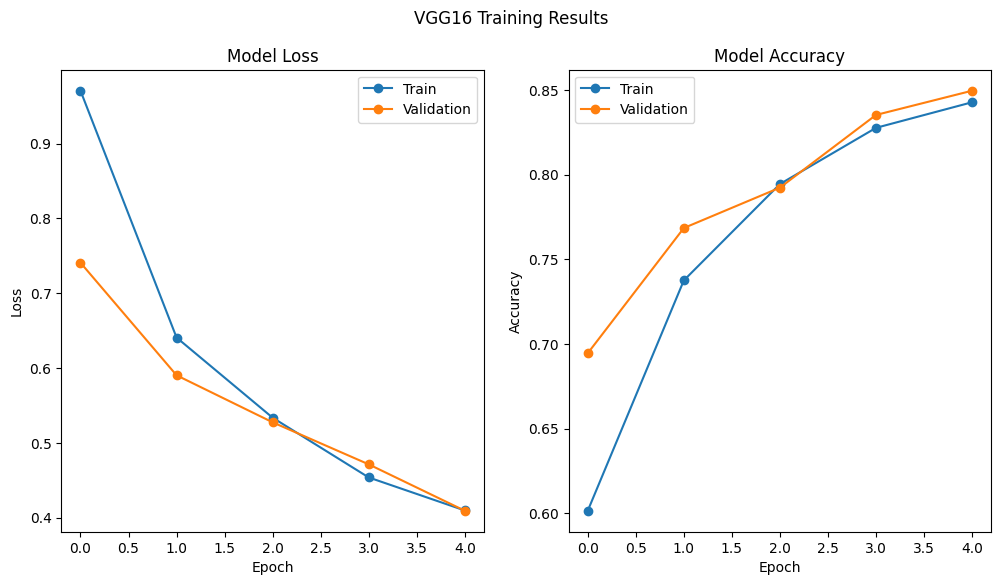

In [ ]:
plot_training(vgg16_history, "VGG16 Training Results")

In [ ]:
vgg16.save(VGG16_MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**training resnet**

In [ ]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)

In [ ]:
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
resnet50.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 1500)              3073500   
                                                                 
 dropout_3 (Dropout)         (None, 1500)              0         
                                                                 
 dense_22 (Dense)            (None, 200)               300200    
                                                                 
 dense_23 (Dense)            (None, 4)                 804       
                                                      

In [ ]:
resnet50 = Sequential([
    resnet50,
    Flatten(),
    Dense(200, activation='relu'),
    Dense(4, activation='softmax')
])


In [ ]:
resnet50.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 4)                 26962216  
                                                                 
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_39 (Dense)            (None, 1500)              7500      
                                                                 
 dense_40 (Dense)            (None, 200)               300200    
                                                                 
 dense_41 (Dense)            (None, 4)                 804       
                                                                 
Total params: 27270720 (104.03 MB)
Trainable params: 27217600 (103.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
resnet50.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
resnet50_history = resnet50.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/5
53/53 [==============================] - 90s 1s/step - loss: 1.1597 - accuracy: 0.6136 - val_loss: 1.5267 - val_accuracy: 0.2554
Epoch 2/5
53/53 [==============================] - 50s 944ms/step - loss: 1.0290 - accuracy: 0.5706 - val_loss: 2.1401 - val_accuracy: 0.1909
Epoch 3/5
53/53 [==============================] - 50s 948ms/step - loss: 0.9929 - accuracy: 0.5599 - val_loss: 2.2199 - val_accuracy: 0.2601
Epoch 4/5
53/53 [==============================] - 49s 911ms/step - loss: 0.9592 - accuracy: 0.6035 - val_loss: 2.2280 - val_accuracy: 0.2601
Epoch 5/5
53/53 [==============================] - 48s 906ms/step - loss: 0.8922 - accuracy: 0.6329 - val_loss: 2.4593 - val_accuracy: 0.2601


In [ ]:
test_loss, test_accuracy = resnet50.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

7/7 [==============================] - 5s 674ms/step - loss: 2.4575 - accuracy: 0.2606
Test Loss: 2.4575448036193848
Test Accuracy: 0.26056337356567383


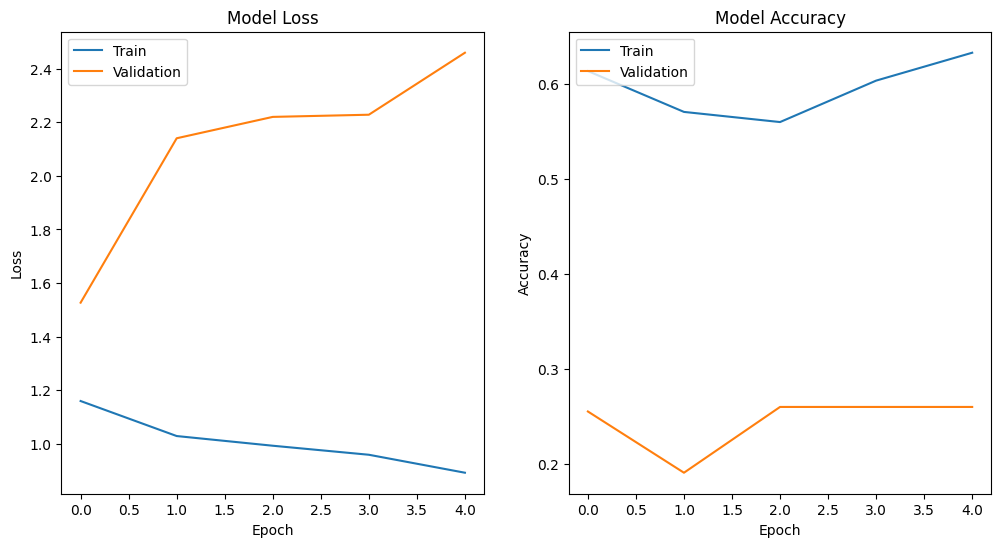

In [ ]:
plot_training(resnet50_history, "ResNet50 Training Results")

In [ ]:
resnet50.save(RESNET50_MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**training InceptionV3**

In [ ]:
inceptionV3 = InceptionV3(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)

In [ ]:
for layer in inceptionV3.layers:
    layer.trainable = False

In [ ]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
inceptionV3 = Sequential([
    inceptionV3,
    Flatten(),
    Dense(200, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
inceptionV3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_50 (Dense)            (None, 200)               10240200  
                                                                 
 dense_51 (Dense)            (None, 4)                 804       
                                                                 
Total params: 32043788 (122.24 MB)
Trainable params: 10241004 (39.07 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
inceptionV3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
inceptionV3_history = inceptionV3.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=64
)


Epoch 1/5
53/53 [==============================] - 48s 781ms/step - loss: 7.9445 - accuracy: 0.6157 - val_loss: 0.8173 - val_accuracy: 0.7733
Epoch 2/5
53/53 [==============================] - 40s 758ms/step - loss: 0.4377 - accuracy: 0.8491 - val_loss: 0.4019 - val_accuracy: 0.8401
Epoch 3/5
53/53 [==============================] - 40s 756ms/step - loss: 0.2562 - accuracy: 0.9039 - val_loss: 0.4686 - val_accuracy: 0.8544
Epoch 4/5
53/53 [==============================] - 40s 750ms/step - loss: 0.1926 - accuracy: 0.9303 - val_loss: 0.3490 - val_accuracy: 0.8663
Epoch 5/5
53/53 [==============================] - 41s 775ms/step - loss: 0.1227 - accuracy: 0.9626 - val_loss: 0.4742 - val_accuracy: 0.8305


In [ ]:
test_loss, test_accuracy = inceptionV3.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

7/7 [==============================] - 4s 546ms/step - loss: 0.5828 - accuracy: 0.8169
Test Loss: 0.5827553272247314
Test Accuracy: 0.8169013857841492


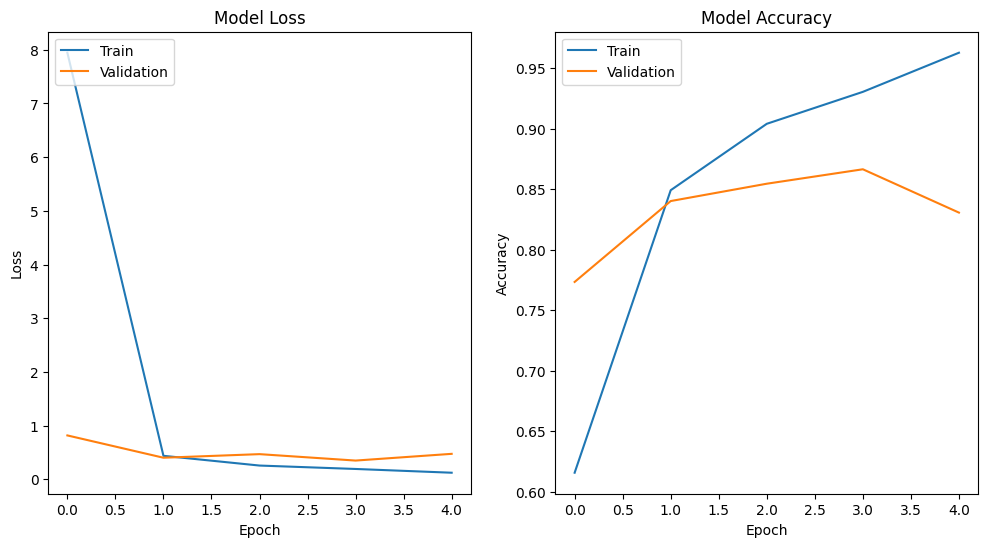

In [ ]:
plot_training(inceptionV3_history, "InceptionV3 Training Results")

In [ ]:
inceptionV3.save(INCEPTION_V3_MODEL_PATH)

## **3.2 implementing ensemble model**

In [ ]:
from keras.models import Model, load_model
from keras.layers import Average, Input

In [ ]:
vgg16 = load_model(VGG16_MODEL_PATH)
vgg16_model = Model(inputs=vgg16.inputs,
                       outputs=vgg16.outputs,
                       name='VGG16_model')

resnet = load_model(RESNET50_MODEL_PATH)
resnet_model = Model(inputs=resnet.inputs,
                            outputs=resnet.outputs,
                            name='ResNet50_model')

inceptionV3 = load_model(INCEPTION_V3_MODEL_PATH)
inceptionV3_model = Model(inputs=inceptionV3.inputs,
                            outputs=inceptionV3.outputs,
                            name='inceptionV3_model')

# trained_models = [vgg16_model, resnet_model, inceptionV3_model]
trained_models = [vgg16_model,  inceptionV3_model]

model_input = Input(shape=IMAGE_SIZE)

model_outputs = [model(model_input) for model in trained_models]
ensemble_output = Average()(model_outputs)

ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
ensemble_history = ensemble_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/5
53/53 [==============================] - 56s 855ms/step - loss: 0.5831 - accuracy: 0.6655 - val_loss: 0.4979 - val_accuracy: 0.7208
Epoch 2/5
53/53 [==============================] - 43s 812ms/step - loss: 0.4461 - accuracy: 0.7310 - val_loss: 0.4774 - val_accuracy: 0.7303
Epoch 3/5
53/53 [==============================] - 44s 816ms/step - loss: 0.3951 - accuracy: 0.7912 - val_loss: 0.4102 - val_accuracy: 0.8353
Epoch 4/5
53/53 [==============================] - 44s 830ms/step - loss: 0.2904 - accuracy: 0.8962 - val_loss: 0.4044 - val_accuracy: 0.8258
Epoch 5/5
53/53 [==============================] - 44s 826ms/step - loss: 0.2441 - accuracy: 0.9173 - val_loss: 0.3503 - val_accuracy: 0.8735


In [ ]:
test_loss, test_accuracy = ensemble_model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

7/7 [==============================] - 5s 580ms/step - loss: 0.3455 - accuracy: 0.8685
Test Loss: 0.3454797565937042
Test Accuracy: 0.8685445785522461


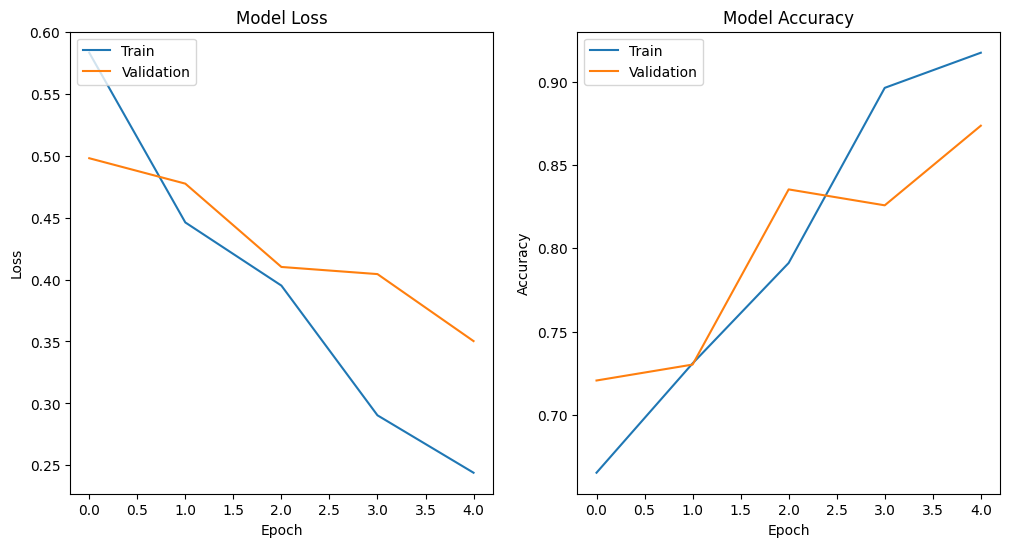

In [ ]:
plot_training(ensemble_history, "Ensemble Model Training Results")

In [ ]:
ensemble_model.save(ENSEMBLE_MODEL_PATH)

## **3.3 implementing weighted ensembling**

In [18]:
from keras.layers import Layer

In [19]:
class WeightedAverageLayer(Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3= w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]+ self.w3 * inputs[2]

In [ ]:
vgg16 = load_model(VGG16_MODEL_PATH)
vgg16_model = Model(inputs=vgg16.inputs,
                       outputs=vgg16.outputs,
                       name='VGG16_model')

resnet = load_model(RESNET50_MODEL_PATH)
resnet_model = Model(inputs=resnet.inputs,
                            outputs=resnet.outputs,
                            name='ResNet50_model')

inceptionV3 = load_model(INCEPTION_V3_MODEL_PATH)
inceptionV3_model = Model(inputs=inceptionV3.inputs,
                            outputs=inceptionV3.outputs,
                            name='inceptionV3_model')


trained_models = [inceptionV3_model, vgg16_model, resnet_model]
# trained_models = [vgg16_model,  inceptionV3_model]

model_input = Input(shape=IMAGE_SIZE)

model_outputs = [model(model_input) for model in trained_models]
ensemble_output = WeightedAverageLayer(0.6, 0.3, 0.1)(model_outputs)

weighted_ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='weighted-ensemble')

In [ ]:
weighted_ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
weighted_ensemble_history = weighted_ensemble_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/5
53/53 [==============================] - 56s 908ms/step - loss: 0.6031 - accuracy: 0.6406 - val_loss: 0.5735 - val_accuracy: 0.6563
Epoch 2/5
53/53 [==============================] - 48s 902ms/step - loss: 0.5149 - accuracy: 0.6954 - val_loss: 0.4995 - val_accuracy: 0.7494
Epoch 3/5
53/53 [==============================] - 46s 857ms/step - loss: 0.4287 - accuracy: 0.7758 - val_loss: 0.4271 - val_accuracy: 0.7804
Epoch 4/5
53/53 [==============================] - 52s 966ms/step - loss: 0.3573 - accuracy: 0.8443 - val_loss: 0.3440 - val_accuracy: 0.8377
Epoch 5/5
53/53 [==============================] - 47s 874ms/step - loss: 0.2831 - accuracy: 0.8900 - val_loss: 0.3394 - val_accuracy: 0.8473


In [ ]:
test_loss, test_accuracy = weighted_ensemble_model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

7/7 [==============================] - 11s 902ms/step - loss: 0.3585 - accuracy: 0.8310
Test Loss: 0.3584688901901245
Test Accuracy: 0.8309859037399292


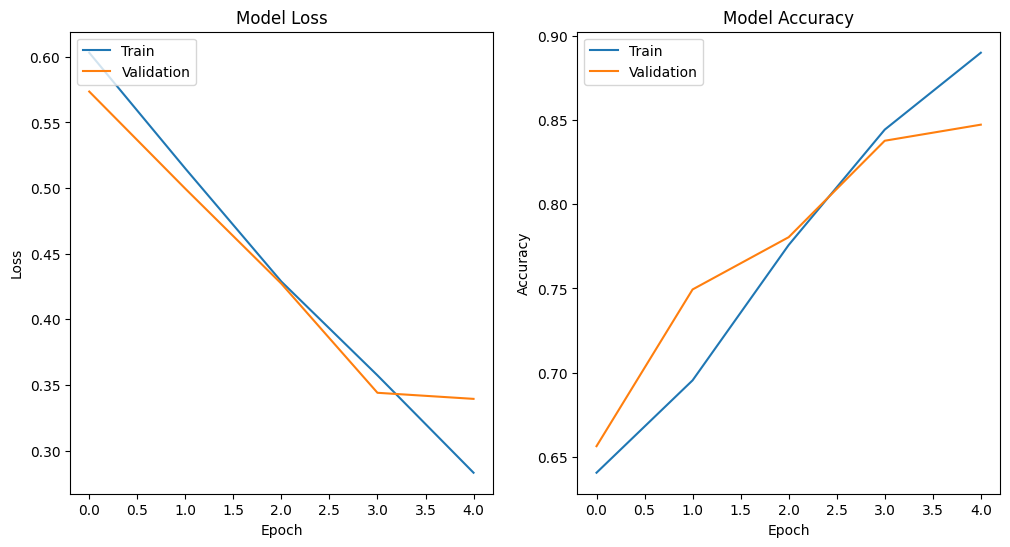

In [ ]:
plot_training(weighted_ensemble_history, "Weighted Ensemble Model Training Results")

In [ ]:
weighted_ensemble_model.save(WEIGHTED_ENSEMBLE_MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4. Testing Model

In [6]:
from keras.models import load_model
import numpy as np
from PIL import Image, ImageOps
import requests
import tensorflow as tf

class_labels = ['Cataract', 'diabetic_retinopathy', 'glaucoma', 'Normal']

# fname = "class.txt"
# with open(fname ,"r") as f:
#     class_labels = sorted(set([word for line in f for word in line.split()]))


def load_and_prep_image(filepath, image_size):
    img = tf.io.read_file(filepath) #read image

    img = tf.io.decode_image(img,channels=3)
    # img = tf.image.decode_image(img) # decode the image to a tensor
    img = tf.image.resize(img, size = [image_size, image_size]) # resize the image
    img = img/255. # rescale the image
    return img

def classify_image(filepath, model_path, image_size=229, class_labels=class_labels):
    # loading trained model
    trained_model=load_model(model_path, compile=False)
    trained_model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    # Import the target image and preprocess it
    img = load_and_prep_image(filepath, image_size)

    prediction = trained_model.predict(tf.expand_dims(img, axis=0))
    index = np.argmax(prediction)

    class_name = class_labels[index]
    confidence_score = prediction[0][index]

    return {
        'class' : class_name,
        'score' : f'{confidence_score*100:02.2f}%'
    }

def predict_class(filepath, model_path, image_size = 299):
    np.set_printoptions(suppress=True)

    model = load_model(model_path ,compile=False)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    data = np.ndarray(shape=(1, image_size, image_size, 3), dtype=np.float32)

    # Replace this with the path to your image
    image = Image.open(filepath).convert("RGB")

    # resizing the image to be at least 299 X 299 and then cropping from the center
    size = (image_size, image_size)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    # turn the image into a numpy array
    image_array = np.asarray(image)

    # Normalize the image
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Load the image into the array
    data[0] = normalized_image_array

    # Predicts the model
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_labels[index]
    confidence_score = prediction[0][index]

    result = {
        "class" : class_name,
        "score" :f'{(confidence_score*100):2.2f}%'
    }

    return result

def prepare_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [image_size, image_size])

    image = np.expand_dims(image, axis=0)

    return image

def classify_using_bytes(image_bytes, model_path, image_size):
    model = load_model(model_path, compile=False)
    model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    prediction = model.predict(prepare_image(image_bytes, image_size))
    index = np.argmax(prediction, axis=1)[0]

    class_name = class_labels[index]
    confidence_score = prediction[0][index]

    return {
        'class' : class_name,
        'score' : f'{confidence_score*100:02.2f}%'
    }

def classify_using_url(url, model_path, image_size=299):
    image_source = requests.get(url).content

    return classify_using_bytes(image_source, model_path, image_size)


In [ ]:
image_size = 224

In [8]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/normal/2334_right.jpg"
classify_image(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 3s 3s/step


{'class': 'Normal', 'score': '93.86%'}

In [10]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/diabetic_retinopathy/10081_right.jpeg"
predict_class(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 0s 138ms/step


{'class': 'diabetic_retinopathy', 'score': '99.61%'}

In [11]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/glaucoma/1212_left.jpg"
predict_class(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 0s 197ms/step


{'class': 'glaucoma', 'score': '56.56%'}

In [22]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/cataract/2101_right.jpg"
predict_class(filepath, ENSEMBLE_MODEL_PATH, image_size)

1/1 [==============================] - 3s 3s/step


{'class': 'Cataract', 'score': '89.02%'}

In [23]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/cataract/2101_right.jpg"
predict_class(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 0s 239ms/step


{'class': 'Cataract', 'score': '95.22%'}